In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [170]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_11.json")

df.drop_duplicates(subset=['article_new', 'case_num', 'file', 'section_fin'], keep='first', inplace=True)
df=df.reset_index(drop=True)

We need to remove some obvious words like 'european commission', 'statement objection', etc. These are most likely frequest terms as well.

In [171]:
# Define a regular expression pattern to match the unwanted words
remove_words = ['statement objection', 'en', 'phase ii', 'rfi', 'request information',
                'european commission', 'commission européenne bruxelles', 'europese commissie brussel', 'belgium telephone',
                'confidential information disclosed', 'bruxelles europese', 'européenne', 'commissie', 'europese', 'tele', 'brussel', 'bruxelles',
                'belgique', 'tel', 'belgïë',
                'enclosed square bracket', 'marked asterisk']
remove_pattern = re.compile(r'\b(' + '|'.join(remove_words) + r')\b', flags=re.IGNORECASE)
df['text_clean'] = df['text_clean'].replace(remove_pattern, '', regex=True)

### Balance data and split to train and test set

In [172]:
label_name = "phase2"

In [173]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [174]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [214]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2),(1,1),(1,3), (2,2),(2,3), (2,4), (3,3), (3,4)], #(1,2),(1,1),(1,3),
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [9]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1')

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
done in 2814.584s
Best cross-validation score:  0.9348109517601043
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (3, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


##### Model fitting and evaluation

In [10]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=3)

fitting the best model
Accuracy: 0.9299363057324841

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93        79
           1       0.89      0.97      0.93        78

    accuracy                           0.93       157
   macro avg       0.93      0.93      0.93       157
weighted avg       0.93      0.93      0.93       157


CR: (0.9331699346405229, 0.9302174618630314, 0.9298338276520538, None)

Confusion matrix:
 [[70  9]
 [ 2 76]] 

_______________________


 Accuracy: 92.99 
 Precision: 0.894 
 Recall: 0.974 
 F1: 0.933


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [11]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/tables/features_svm_cv_full.xlsx', index=True)
df_features_cv.head()

,feature,importance
1565,europese commissie brussel,-0.651748
898,confidential information disclosed,0.620311
2027,information disclosed enclosed,0.620311
1321,disclosed enclosed square,0.620311
1481,enclosed square bracket,0.618612


In [12]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9755073477956613

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1409
           1       0.35      0.90      0.51        20

    accuracy                           0.98      1429
   macro avg       0.68      0.94      0.75      1429
weighted avg       0.99      0.98      0.98      1429


CR: (0.6757448988303595, 0.9382895670688431, 0.7472419735492251, None)

Confusion matrix:
 [[1376   33]
 [   2   18]] 

_______________________


 Accuracy: 97.55 
 Precision: 0.353 
 Recall: 0.900 
 F1: 0.507


### Model training (with 10-fold CV) using best parameters from GridSearch

In [175]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (3, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


In [230]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (3,3), binary = True, max_df = 0.025, norm = 'l2', use_idf = True))
c = 5
# solver = 'liblinear'
model=LinearSVC(C=c)

In [231]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.7707006369426752

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.70      0.75        79
           1       0.73      0.85      0.79        78

    accuracy                           0.77       157
   macro avg       0.78      0.77      0.77       157
weighted avg       0.78      0.77      0.77       157


CR: (0.7771144278606965, 0.7711781888997079, 0.769569471624266, None)

Confusion matrix:
 [[55 24]
 [12 66]] 

_______________________


 Accuracy: 77.07 
 Precision: 0.733 
 Recall: 0.846 
 F1: 0.786


In [232]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.7984604618614416

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89      1409
           1       0.06      0.85      0.11        20

    accuracy                           0.80      1429
   macro avg       0.53      0.82      0.50      1429
weighted avg       0.98      0.80      0.88      1429


CR: (0.5268147281947619, 0.8238644428672818, 0.49601269667104253, None)

Confusion matrix:
 [[1124  285]
 [   3   17]] 

_______________________


 Accuracy: 79.85 
 Precision: 0.056 
 Recall: 0.850 
 F1: 0.106


### Feature importance

In [233]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
4516,state austria germany,-0.832336,0.832336
2247,large industrial commercial,-0.736454,0.736454
1548,exceeding eur million,0.710983,0.710983
1549,exceeds cid million,-0.671145,0.671145
2894,new business model,-0.583586,0.583586
2757,narrowly defined market,-0.572051,0.572051
298,basis long term,0.567167,0.567167
115,agreement publication official,-0.559486,0.559486
362,billion aggregate community,-0.552653,0.552653
3710,previous case market,-0.550588,0.550588


In [234]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [235]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

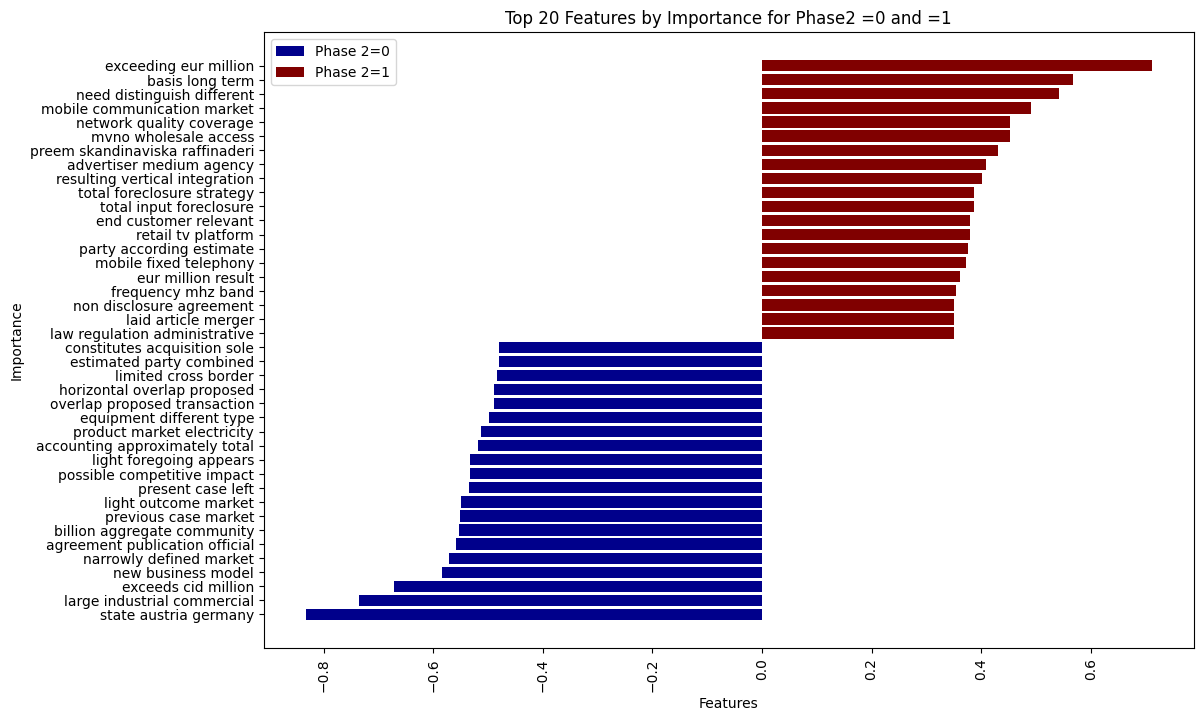

In [239]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [36]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full.xlsx', index=True)